In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, LSTM, Dense, TimeDistributed
from tensorflow.keras.callbacks import ModelCheckpoint
import tensorflow as tf

# Đọc dữ liệu
df = pd.read_csv("data.csv")
df['time'] = pd.to_datetime(df['time'])
print(df.head())
print(df.info())


                 time  x  y    dust   temp  humidity     MQ2     MQ7
0 2025-08-05 14:23:22  1  1   52.79  22.60     80.81  222.30  223.86
1 2025-08-05 14:23:22  1  2   76.64  25.82     72.78  353.77  356.93
2 2025-08-05 14:23:22  1  3  105.26  28.87     61.51  506.72  506.04
3 2025-08-05 14:23:22  1  4  134.13  32.32     53.17  648.80  659.54
4 2025-08-05 14:23:22  1  5  145.08  33.78     49.17  706.99  710.27
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 863975 entries, 0 to 863974
Data columns (total 8 columns):
 #   Column    Non-Null Count   Dtype         
---  ------    --------------   -----         
 0   time      863975 non-null  datetime64[ns]
 1   x         863975 non-null  int64         
 2   y         863975 non-null  int64         
 3   dust      863975 non-null  float64       
 4   temp      863975 non-null  float64       
 5   humidity  863975 non-null  float64       
 6   MQ2       863975 non-null  float64       
 7   MQ7       863975 non-null  float64       
dtypes

In [5]:
# Nội suy và thay NaN
df.interpolate(method='linear', inplace=True)
num_cols = df.select_dtypes(include=[np.number]).columns
df[num_cols] = df[num_cols].fillna(df[num_cols].mean())

# Các thông số cảm biến
features = ["dust", "temp", "humidity", "MQ2", "MQ7"]
grid_size = 5

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler()
df[features] = scaler.fit_transform(df[features])

print("Dữ liệu sau khi xử lý:")
print(df.head())


Dữ liệu sau khi xử lý:
                 time  x  y      dust      temp  humidity       MQ2       MQ7
0 2025-08-05 14:23:22  1  1  0.052602  0.045822  0.920303  0.048251  0.050132
1 2025-08-05 14:23:22  1  2  0.203027  0.219407  0.779029  0.207120  0.210921
2 2025-08-05 14:23:22  1  3  0.383538  0.383827  0.580753  0.391945  0.391090
3 2025-08-05 14:23:22  1  4  0.565626  0.569811  0.434025  0.563634  0.576564
4 2025-08-05 14:23:22  1  5  0.634689  0.648518  0.363652  0.633951  0.637861


In [6]:
time_steps = 5   # số bước input
future_steps = 1 # dự đoán 1 bước

X, y = [], []
unique_times = np.sort(df['time'].unique())

for i in range(len(unique_times) - time_steps - future_steps + 1):
    time_window = unique_times[i:i+time_steps]
    future_time = unique_times[i+time_steps]

    X_block = []
    for t in time_window:
        snapshot = df[df['time'] == t].sort_values(['x', 'y'])[features].values.reshape(grid_size, grid_size, len(features))
        X_block.append(snapshot)

    y_block = df[df['time'] == future_time].sort_values(['x', 'y'])[features].values.flatten()

    X.append(X_block)
    y.append(y_block)

X = np.array(X)
y = np.array(y)

print(f"Shape X: {X.shape}, y: {y.shape}")


Shape X: (34554, 5, 5, 5, 5), y: (34554, 125)


In [7]:
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)

X_train, X_val, X_test = X[:train_size], X[train_size:train_size+val_size], X[train_size+val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size+val_size], y[train_size+val_size:]


In [8]:
model = Sequential([
    TimeDistributed(Conv2D(32, (3,3), activation='relu'), input_shape=(time_steps, grid_size, grid_size, len(features))),
    TimeDistributed(MaxPooling2D((2,2))),
    TimeDistributed(Flatten()),
    LSTM(64, activation='relu'),
    Dense(grid_size*grid_size*len(features))
])
model.compile(optimizer='adam', loss='mse')
model.summary()


C:\Users\ADMIN\AppData\Roaming\Python\Python312\site-packages\keras\src\layers\core\wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ time_distributed_3              │ (None, 5, 3, 3, 32)    │         1,472 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_4              │ (None, 5, 1, 1, 32)    │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ time_distributed_5              │ (None, 5, 32)          │             0 │
│ (TimeDistributed)               │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_1 (LSTM)                   │ (None, 64)             │        24,832 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 125)            │         8,125 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 34,429 (134.49 KB)

 Trainable params: 34,429 (134.49 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/30
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 0.0259 - val_loss: 0.0043
Epoch 2/30
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.6725e-04 - val_loss: 0.0036
Epoch 3/30
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.5784e-04 - val_loss: 0.0039
Epoch 4/30
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4752e-04 - val_loss: 0.0037
Epoch 5/30
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.4300e-04 - val_loss: 0.0037
Epoch 6/30
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 4ms/step - loss: 1.4149e-04 - val_loss: 0.0031
Epoch 7/30
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.3659e-04 - val_loss: 0.0032
Epoch 8/30
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.3893e-04 - val_loss: 0.0036
Epoch 9/30
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.3519e-04 - val_loss: 0.0031
Epoch 10/30
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.3123e-04 - val_loss: 0.0033
Epoch 11/30
1512/1512 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 1.3133e-04 - val_los

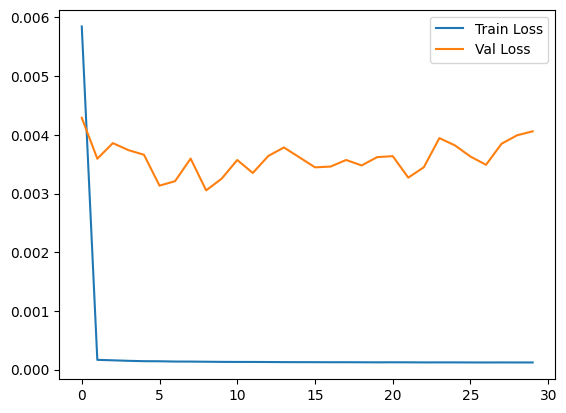

In [9]:
checkpoint = ModelCheckpoint("best_cnn_lstm.keras", monitor='val_loss', save_best_only=True)
history = model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=30, batch_size=16, callbacks=[checkpoint])

# Vẽ loss
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.legend()
plt.show()


In [10]:
y_pred_test = model.predict(X_test)
rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
print(f"Test RMSE: {rmse_test:.4f}")


162/162 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step
Test RMSE: 0.0681


In [11]:
best_model = load_model("best_cnn_lstm.keras")
print("Best model loaded.")


Best model loaded.


In [12]:
threshold_rmse = 0.1
continuous_preds = []
prediction_times = []

current_input = X_test[0:1]  # Lấy sample đầu tiên
current_time_index = 0

for step in range(50):
    y_pred = best_model.predict(current_input, verbose=0)
    y_pred_flat = y_pred.flatten()
    continuous_preds.append(y_pred_flat)
    prediction_times.append(unique_times[train_size+val_size + current_time_index + time_steps])

    # Tính RMSE nếu còn ground truth
    if current_time_index < len(y_test):
        y_true_flat = y_test[current_time_index].flatten()
        rmse = np.sqrt(mean_squared_error(y_true_flat, y_pred_flat))
        print(f"Step {step+1} | RMSE: {rmse:.4f}")
        if rmse > threshold_rmse:
            print(f"Stopping due to high RMSE at step {step+1}")
            break

    # Chuẩn bị input mới
    new_snapshot = y_pred_flat.reshape(grid_size, grid_size, len(features))
    new_snapshot = new_snapshot[np.newaxis, np.newaxis, :, :, :]  # (1,1,grid,grid,features)
    current_input = np.concatenate([current_input[:, 1:], new_snapshot], axis=1)

    current_time_index += 1

continuous_preds = np.array(continuous_preds)


Step 1 | RMSE: 0.0790
Step 2 | RMSE: 0.0864
Step 3 | RMSE: 0.0978
Step 4 | RMSE: 0.1089
Stopping due to high RMSE at step 4


In [15]:
# Unscale từng feature
continuous_preds_unscaled = []
for step_pred in continuous_preds:
    step_pred_reshaped = step_pred.reshape(grid_size*grid_size, len(features))  # (25,5)
    step_pred_unscaled = scaler.inverse_transform(step_pred_reshaped)           # (25,5)
    continuous_preds_unscaled.append(step_pred_unscaled.flatten())              # flatten lại 125
continuous_preds_unscaled = np.array(continuous_preds_unscaled)                # (num_steps, 125)

# Chuyển thành DataFrame
results_list = []
for t_idx, pred_flat in enumerate(continuous_preds_unscaled):
    snapshot = pred_flat.reshape(grid_size, grid_size, len(features))
    for i in range(grid_size):
        for j in range(grid_size):
            row_data = {"time": prediction_times[t_idx], "x": i, "y": j}
            for f_idx, f_name in enumerate(features):
                row_data[f_name] = snapshot[i, j, f_idx]
            results_list.append(row_data)

df_predictions = pd.DataFrame(results_list)
df_predictions.to_csv("continuous_predictions_unscaled.csv", index=False)
print("Saved predictions to continuous_predictions_unscaled.csv")


Saved predictions to continuous_predictions_unscaled.csv


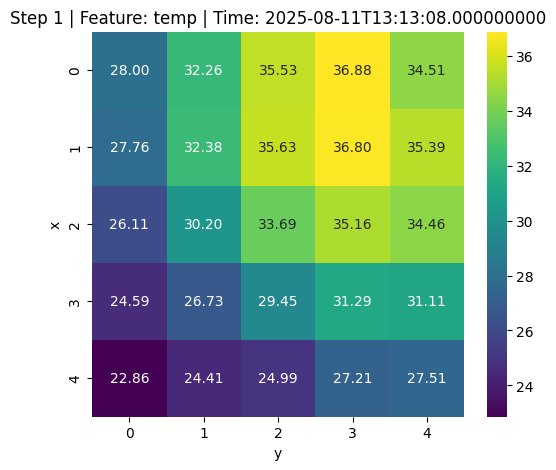

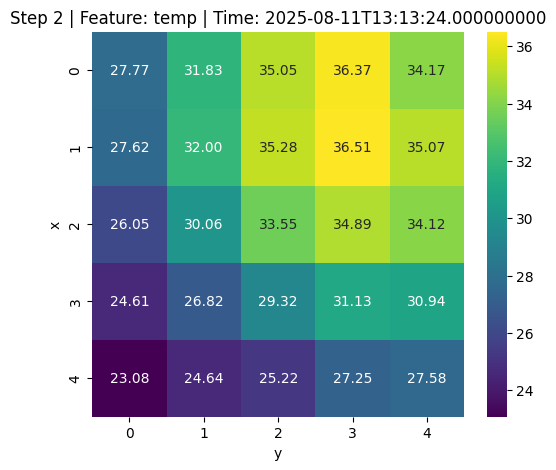

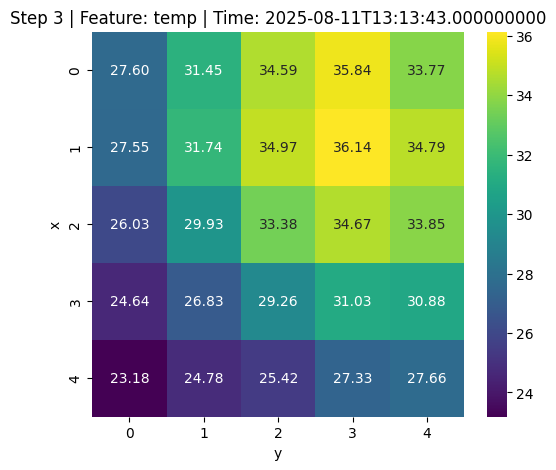

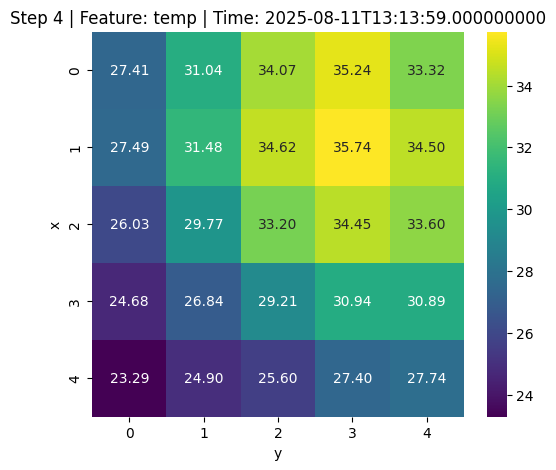

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# Chọn feature muốn hiển thị
feature_to_plot = "temp"  # có thể chọn "dust", "temp", "humidity", "MQ2", "MQ7"
feature_index = features.index(feature_to_plot)

# Vẽ heatmap cho từng bước dự đoán
for step, pred_flat in enumerate(continuous_preds_unscaled):
    snapshot = pred_flat.reshape(grid_size, grid_size, len(features))
    data_to_plot = snapshot[:, :, feature_index]

    plt.figure(figsize=(6,5))
    sns.heatmap(data_to_plot, annot=True, fmt=".2f", cmap="viridis")
    plt.title(f"Step {step+1} | Feature: {feature_to_plot} | Time: {prediction_times[step]}")
    plt.xlabel("y")
    plt.ylabel("x")
    plt.show()
